# Dataset generation

This notebook documents the creation of a dataset of small I-containing molecules to be optimized and later used for ESP generation. 

All I-containing molecules were selected from the ZINC, enamine, and CHEMBL datasets. These molecules were then fragmented, and small fragments containing I were kept. Protomers were then enumerated. The results of this process are stored in `enumerated.smi`. 

In this document we generate ELF conformers for each molecule and create an OptimizationDataset.

# Import

In [3]:
import openff.qcsubmit
import openff.toolkit
import openeye
import qcelemental
import qcportal

print("OpenFF QCSubmit:", openff.qcsubmit.__version__)
print("OpenFF Toolkit:", openff.toolkit.__version__)
print("OpenEye:", openeye.__version__)
print("QCElemental:", qcelemental.__version__)
print("QCPortal:", qcportal.__version__)

OpenFF QCSubmit: 0.53.0
OpenFF Toolkit: 0.16.4
OpenEye: 2024.1.0
QCElemental: 0.28.0
QCPortal: 0.56


In [4]:
import tqdm

from openff.units import unit

from openff.toolkit import Molecule
from openff.toolkit.utils import OpenEyeToolkitWrapper, ToolkitRegistry

from openff.qcsubmit.datasets import OptimizationDataset
from openff.qcsubmit.factories import OptimizationDatasetFactory

from qcelemental.models.results import WavefunctionProtocolEnum

# Setting up dataset

In [5]:
dataset_factory = OptimizationDatasetFactory()
provenance = dataset_factory.provenance(ToolkitRegistry([OpenEyeToolkitWrapper]))

In [9]:
dataset = OptimizationDataset(
    dataset_name="OpenFF Iodine Fragment Opt v1.0",
    dataset_tagline="B3LYP-D3BJ/DZVP optimized conformers for a variety of I-containing fragment molecules", # add method
    description=(
        "A dataset containing fragments of molecules from the "
        "Zinc, enamine, and CHEMBL datasets optimized at the B3LYP-D3BJ/DZVP level of theory. "
        "Molecules containing I were fragmented into small fragments. "
        "Fragments containing I then had protomers enumerated.\n\n"
        "For each resulting molecule, a set of up to 5 conformers were generated by:\n"
        "  * generating a set of up to 1000 conformers with a RMS cutoff of 0.5 Å "
        "using the OpenEye backend of the OpenFF toolkit\n"
        "  * applying ELF conformer selection (max 5 conformers) using OpenEye\n\n"
    ),
    provenance=provenance
)
dataset.metadata.submitter = "amcisaac"
dataset.metadata.long_description_url = (
        "https://github.com/openforcefield/qca-dataset-submission/tree/master/"
        "submissions/"
        "2024-09-10-OpenFF-Iodine-Fragment-Opt-v1.0"
    )


In [10]:
print(dataset.qc_specifications)

{'default': QCSpec(method='B3LYP-D3BJ', basis='DZVP', program='psi4', spec_name='default', spec_description='Standard OpenFF optimization quantum chemistry specification.', store_wavefunction=<WavefunctionProtocolEnum.none: 'none'>, implicit_solvent=None, maxiter=200, scf_properties=[<SCFProperties.Dipole: 'dipole'>, <SCFProperties.Quadrupole: 'quadrupole'>, <SCFProperties.WibergLowdinIndices: 'wiberg_lowdin_indices'>, <SCFProperties.MayerIndices: 'mayer_indices'>], keywords={})}


In [11]:
print(dataset.description)

A dataset containing fragments of molecules from the Zinc, enamine, and CHEMBL datasets optimized at the B3LYP-D3BJ/DZVP level of theory. Molecules containing I were fragmented into small fragments. Fragments containing I then had protomers enumerated.

For each resulting molecule, a set of up to 5 conformers were generated by:
  * generating a set of up to 1000 conformers with a RMS cutoff of 0.5 Å using the OpenEye backend of the OpenFF toolkit
  * applying ELF conformer selection (max 5 conformers) using OpenEye




# Generate conformers

In [12]:
with open("enumerated.smi", "r") as f:
    smiles = [x.strip() for x in f.readlines()]

In [13]:
# Taken from the multi-Br optimization submission
def generate_conformers(smiles: str) -> Molecule:
    wrapper = OpenEyeToolkitWrapper()
    
    mol = Molecule.from_smiles(
        smiles,
        allow_undefined_stereo=True,
        toolkit_registry=wrapper,
    )
    # generate max 1000 conformers with OpenEye
    mol.generate_conformers(
        n_conformers=1000,
        rms_cutoff=0.5 * unit.angstrom,
        toolkit_registry=wrapper,
    )
    
    # prune based on ELF method, max 5 conformers output
    mol.apply_elf_conformer_selection(
        percentage=2.0,
        limit=5,
        toolkit_registry=wrapper
    )
    
    assert mol.n_conformers > 0
    
    return mol

In [14]:
for smi in tqdm.tqdm(smiles, desc="generating conformers"):
    mol = generate_conformers(smi)
    dataset.add_molecule(
        dataset_factory.create_index(molecule=mol),
        mol
    )

generating conformers: 100%|██████████████████████████████████████████████████████| 526/526 [01:14<00:00,  7.07it/s]


# Exporting dataset

In [15]:
dataset.export_dataset("dataset.json.bz2")
dataset.molecules_to_file('dataset.smi', 'smi')
dataset.visualize("dataset.pdf", columns=8)


# Dataset information

In [16]:
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt

In [17]:
confs = np.array([len(mol.conformers) for mol in dataset.molecules])

print("* Number of unique molecules:", dataset.n_molecules)
print("* Number of conformers:", sum(confs))
print("* Number of conformers per molecule (min, mean, max): "
      f"{confs.min()}, {confs.mean():.2f}, {confs.max()}")

masses = [
    [
        sum([atom.mass.m for atom in molecule.atoms])
        for molecule in dataset.molecules
    ]
]
print(f'* Molecular weight (min, mean, max): ({np.min(np.array(masses)):.2f}, {np.mean(np.array(masses)):.2f}, {np.max(np.array(masses)):.2f})')
print("* Charges:", sorted(set(m.total_charge.m for m in dataset.molecules)))

* Number of unique molecules: 526
* Number of conformers: 531
* Number of conformers per molecule (min, mean, max): 1, 1.01, 5
* Molecular weight (min, mean, max): (155.97, 242.52, 316.94)
* Charges: [-1.0, 0.0, 1.0, 2.0]


In [18]:
print("## Metadata")
print(f"* Elements: {{{', '.join(dataset.metadata.dict()['elements'])}}}")

def print_field(od, field): print(f"\t* {field}: {od[field]}")

fields = ["basis", "implicit_solvent", "keywords", "maxiter", "method", "program"]
for spec, obj in dataset.qc_specifications.items():
    od = obj.dict()
    print("* Spec:", spec)
    for field in fields:
        print_field(od, field)
    print("\t* SCF properties:")
    for field in od["scf_properties"]:
        print(f"\t\t* {field}")

## Metadata
* Elements: {O, C, Cl, I, H, N, F, Br, S}
* Spec: default
	* basis: DZVP
	* implicit_solvent: None
	* keywords: {}
	* maxiter: 200
	* method: B3LYP-D3BJ
	* program: psi4
	* SCF properties:
		* dipole
		* quadrupole
		* wiberg_lowdin_indices
		* mayer_indices


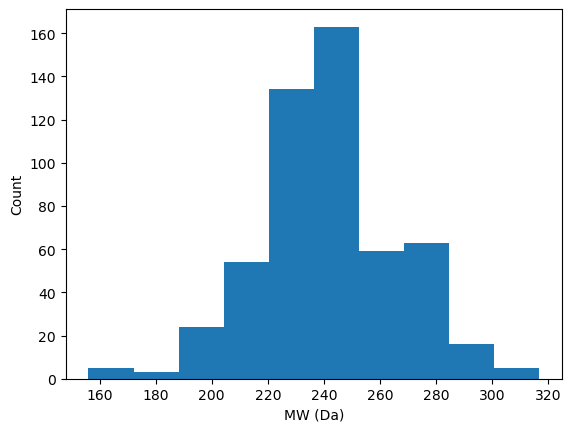

In [19]:
plt.figure()
plt.hist(masses)
plt.ylabel('Count')
plt.xlabel('MW (Da)')
plt.show()

In [20]:
all_atoms = [atom.symbol
    for mol in dataset.molecules
    for atom in mol.atoms]

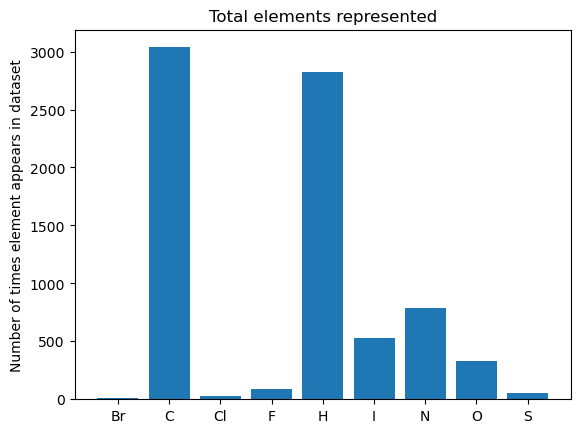

In [21]:
all_atoms_labels, all_atoms_counts = np.unique(all_atoms,return_counts=True)
plt.plot()
plt.bar(all_atoms_labels,all_atoms_counts)
plt.ylabel('Number of times element appears in dataset')
plt.title('Total elements represented')
plt.show()

In [22]:
atoms = []
for mol in dataset.molecules:
    atoms.extend(np.unique([atom.symbol for atom in mol.atoms]))

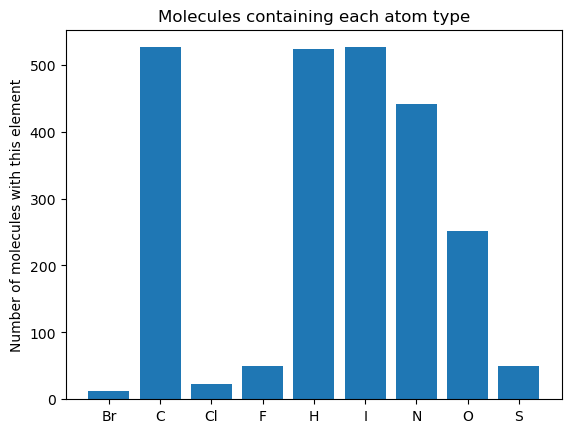

In [23]:
atoms_labels,atoms_counts = np.unique(atoms,return_counts=True)

plt.plot()
plt.bar(atoms_labels,atoms_counts)
plt.ylabel('Number of molecules with this element')
plt.title("Molecules containing each atom type")
plt.show()